# State Preparation via Alias Sampling

Gates for preparing coefficient states.

In section III.D. of the [Linear T paper](https://arxiv.org/abs/1805.03662) the authors introduce
a technique for initializing a state with $L$ unique coefficients (provided by a classical
database) with a number of T gates scaling as 4L + O(log(1/eps)) where eps is the
largest absolute error that one can tolerate in the prepared amplitudes.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `StatePreparationAliasSampling`
Initialize a state with $L$ coefficients using coherent alias sampling.

In particular, given coefficients $w_\ell$, we take the zero state to:

$$
\sum_{\ell=0}^{L-1} \sqrt{p_\ell} |\ell\rangle |\mathrm{temp}_\ell\rangle
$$

where the probabilities $p_\ell$ are $\mu$-bit binary approximations to the true values
$w_\ell / \lambda$ (where $\lambda = \sum_\ell w_\ell$).
Note that the temporary register must be treated with care, see the details in Section III.D.
of the reference.

This construction is designed to work specifically when you don't require specific phases,
and the problem is reduced to [classical alias sampling]
(https://en.wikipedia.org/wiki/Alias_method). We sample `l` with probability `p[l]` by first
selecting `l` uniformly at random and then returning it with probability `keep[l] / 2**mu`;
otherwise returning `alt[l]`.

This gate corresponds to the following operations:
 - UNIFORM_L on the selection register
 - H^mu on the sigma register
 - QROM addressed by the selection register into the alt and keep signature.
 - LessThanEqualGate comparing the keep and sigma signature.
 - Coherent swap between the selection register and alt register if the comparison
   returns True.

Total space will be (2 * log(L) + 2 mu + 1) work qubits + log(L) ancillas for QROM.
The 1 ancilla in work qubits is for the `LessThanEqualGate` followed by coherent swap.

#### Registers
 - `selection`: The input/output register $|\mathrm{ind}_l\rangle$ of size lg(L) where the desired coefficient state is prepared. Default name is 'selection' if the builder methods on the class are used. Or else, users can specify custom named registers
 - `sigma_mu`: A mu-sized register containing uniform probabilities for comparison against `keep`.
 - `alt`: A lg(L)-sized register of alternate indices
 - `keep`: a mu-sized register of probabilities of keeping the initially sampled index.
 - `less_than_equal`: one bit for the result of the comparison. 

#### Parameters
 - `selection_registers`: The input/output registers to prepare the state on (see Registers section).
 - `keep`: The discretized `keep` probabilities for alias sampling.
 - `alt`: The alternate/alias values to swap.
 - `mu`: The number of bits to approximate the `keep` probabilities.
 - `sum_of_unnormalized_probabilities`: The total of the input unnormalized probabilities, i.e., $\lambda$. This is used as the `PrepareOracle.l1_norm_of_coeffs` property. 

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662). Babbush et. al. (2018). Section III.D. and Figure 11.


In [2]:
from qualtran.bloqs.state_preparation import StatePreparationAliasSampling

### Example Instances

In [3]:
coeffs = [1.0, 1, 3, 2]
mu = 3
state_prep_alias = StatePreparationAliasSampling.from_probabilities(
    coeffs, precision=2**-mu / len(coeffs) * sum(coeffs)
)

In [4]:
import sympy

n_coeffs, sum_coeff, eps = sympy.symbols(r"L \lambda \epsilon")
state_prep_alias_symb = StatePreparationAliasSampling.from_n_coeff(
    n_coeffs, sum_coeff, precision=eps
)

#### Graphical Signature

In [5]:
from qualtran.drawing import show_bloqs
show_bloqs([state_prep_alias, state_prep_alias_symb],
           ['`state_prep_alias`', '`state_prep_alias_symb`'])

### Call Graph

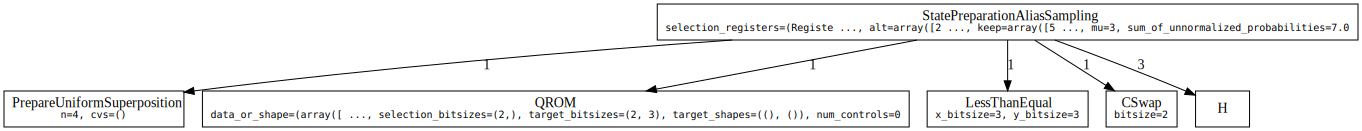

#### Counts totals:
 - `CSwap`: 1
 - `H`: 3
 - `LessThanEqual`: 1
 - `PrepareUniformSuperposition`: 1
 - `QROM`: 1

In [6]:
from qualtran.resource_counting.generalizers import ignore_split_join
state_prep_alias_g, state_prep_alias_sigma = state_prep_alias.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(state_prep_alias_g)
show_counts_sigma(state_prep_alias_sigma)

## `SparseStatePreparationAliasSampling`
Initialize a $d$-sparse state over $L$ indices using coherent alias sampling.

In particular, we take the zero state to:

$$
    \sum_{j=0}^{d-1} \sqrt{p_{\mathrm{ind}_j}} |\mathrm{ind}_j\rangle |\mathrm{temp}_j\rangle
$$

where $\mathrm{ind}_j \in [0, L)$ is the index of the $j$-th non-zero coefficient,
and the probabilities $p_l$ are $\mu$-bit binary approximations to the true values,
and the register $|\mathrm{temp}_j\rangle$ may be entangled with the index register.

This bloq is nearly identical to :class:`StatePreparationByAliasSampling`, except
that it loads the non-zero indices from the QROM and prepares a dense state on them.
In comparison, this uses $\lceil \log d \rceil$ extra ancilla qubits, and reduces
the iteration length to $d$ from $L$.

See :class:`StatePreparationAliasSampling` for an exposition on alias sampling.


#### Registers
 - `selection`: The input/output register $|\mathrm{ind}_l\rangle$ of size lg(L) where the desired coefficient state is prepared.
 - `sigma_mu`: A mu-sized register containing uniform probabilities for comparison against `keep`.
 - `sparse_index`: A lg(d)-sized register storing the sparse index $j \in [0, d)$.
 - `alt`: A lg(L)-sized register of alternate indices
 - `keep`: a mu-sized register of probabilities of keeping the initially sampled index.
 - `less_than_equal`: one bit for the result of the comparison. 

This gate corresponds to the following operations:
 - UNIFORM_d on the `sparse_index` register.
 - H^mu on the `sigma` register.
 - QROM addressed by the `sparse_index` register into the `selection`, `alt`, and `keep` signature.
 - LessThanEqualGate comparing the `keep` and `sigma` registers.
 - Coherent swap between the `selection` and `alt` registers if the comparison returns True.

Total space will be $(2 \log(L) + \log(d) + 2 \mu + 1)$ work qubits + $log(L)$ ancillas for QROM.

#### References
 - [1] [Qubitization of Arbitrary Basis Quantum Chemistry Leveraging Sparsity and Low Rank Factorization](https://arxiv.org/pdf/1902.02134#page=15.30) Berry et al. (2019). Section 5, Eqs. 43, 44. [2] [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662). Babbush et al. (2018). Section III.D. and Figure 11.


In [7]:
from qualtran.bloqs.state_preparation import SparseStatePreparationAliasSampling

### Example Instances

In [8]:
coeff_map = {0: 1.0, 3: 1.0, 5: 3.0, 7: 2.0}
N = 9
mu = 3
sparse_state_prep_alias = SparseStatePreparationAliasSampling.from_sparse_dict(
    coeff_map, N, precision=2**-mu / len(coeff_map)
)

In [9]:
coeffs = [1.0, 0, 0, 1, 0, 3, 0, 2, 0]
mu = 3
sparse_state_prep_alias_from_list = (
    SparseStatePreparationAliasSampling.from_dense_probabilities(coeffs, precision=2**-mu / 4)
)

In [10]:
import sympy

n_coeffs, n_nonzero_coeffs, sum_coeff, eps = sympy.symbols(r"L d \lambda \epsilon")
sparse_state_prep_alias_symb = SparseStatePreparationAliasSampling.from_n_coeff(
    n_coeffs, n_nonzero_coeffs, sum_coeff, precision=eps
)

#### Graphical Signature

In [11]:
from qualtran.drawing import show_bloqs
show_bloqs([sparse_state_prep_alias, sparse_state_prep_alias_from_list, sparse_state_prep_alias_symb],
           ['`sparse_state_prep_alias`', '`sparse_state_prep_alias_from_list`', '`sparse_state_prep_alias_symb`'])

### Call Graph

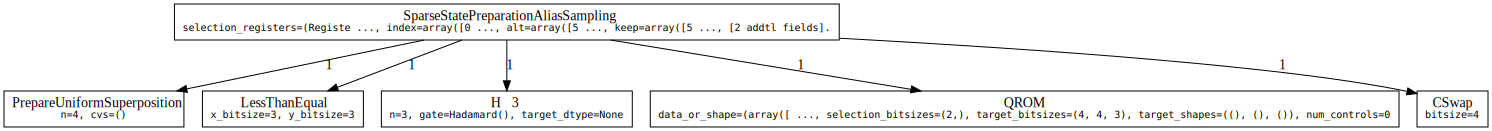

#### Counts totals:
 - `CSwap`: 1
 - `H⨂3`: 1
 - `LessThanEqual`: 1
 - `PrepareUniformSuperposition`: 1
 - `QROM`: 1

In [12]:
from qualtran.resource_counting.generalizers import ignore_split_join
sparse_state_prep_alias_g, sparse_state_prep_alias_sigma = sparse_state_prep_alias.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(sparse_state_prep_alias_g)
show_counts_sigma(sparse_state_prep_alias_sigma)